Before you turn in the homework, make sure everything runs as expected. To do so, select **Kernel**$\rightarrow$**Restart & Run All** in the toolbar above.  Remember to submit both on **DataHub** and **Gradescope**.

Please fill in your name and include a list of your collaborators below.

In [1]:
NAME = "Fangzheng Guo"
COLLABORATORS = ""

---

# Homework 6: Scalable Data Processing Using Ray
Contributors: Peter Schafhalter, Robert Nishihara, Edward Fang, Simon Mo, Devin Petersohn

![ray_logo](https://i.imgur.com/6DHvEJil.jpg)

## Due Date: Friday 12/7, 11:59PM

## Course Policies

Here are some important course policies. These are also located at
http://www.ds100.org/fa18/.

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about
the homework, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your solution.

## This Assignment
Although you've learned powerful techniques for processing data, most of the problems you've worked on involved small datasets that a single machine can quickly process. Data science in practical settings often involves processing hundreds of gigabytes, terabytes, and even petabytes of data. 

These data sets are too large for a single computer to process quickly, so data scientists often *scale up* their programs to *clusters*, many computers working together to run a program. On a smaller scale, we can also parallelize programs across processor cores in a single computer.

For this homework, we will use [Ray](https://ray.readthedocs.io/en/latest/), a system for parallel and distributed Python (developed at Berkeley), which can parallelize programs across the cores of a single computer as well as a cluster. While your code for this homework will only parallelize across the cores of a single JupyterHub computer, you could run it on a cluster as well without any changes.

Throughout this assignment, you may find it helpful to refer to the following:
- [Ray documentation](https://ray.readthedocs.io/en/latest/)
- [Ray codebase](https://github.com/ray-project/ray)

## 1: Learning the Ray API

Let's start by digging into the Ray API and familiarize ourselves with some of its functionalities. Again, please reference the [Ray documentation](https://ray.readthedocs.io/en/latest/) and [Ray codebase](https://github.com/ray-project/ray) if you have any questions.

In [2]:
import numpy as np
import pandas as pd
import re
import scipy.spatial
import time
import urllib.request

import seaborn as sns
import matplotlib.pyplot as plt

from utils import timeit

%matplotlib inline

In [3]:
# To start Ray, we will first import ray and call `ray.init`. 
# We will use 4 cpus. 

# Note that you should only run this cell once!
import ray
ray.init(include_webui=False, num_cpus=4)

Process STDOUT and STDERR is being redirected to /tmp/raylogs/.
Waiting for redis server at 127.0.0.1:51591 to respond...
Waiting for redis server at 127.0.0.1:27514 to respond...
Starting the Plasma object store with 27.00 GB memory.
Starting local scheduler with the following resources: {'CPU': 4, 'GPU': 0}.


{'local_scheduler_socket_names': ['/tmp/scheduler74172999'],
 'node_ip_address': '10.240.0.86',
 'object_store_addresses': [ObjectStoreAddress(name='/tmp/plasma_store77224154', manager_name='/tmp/plasma_manager48981692', manager_port=39575)],
 'raylet_socket_names': [],
 'redis_address': '10.240.0.86:51591',
 'webui_url': ''}

You may have noticed Ray print a line that looks similar to the following:
> `Starting local scheduler with the following resources: {'CPU': 4, 'GPU': 0}.`

This means that we have 4 CPU cores available. In theory, we can parallelize programs to run 4x as fast!

For now, let's start with the basics. With Ray, Python objects can live either within process or within Ray's shared memory which transfers objects between processes in order to share data across different functions that might run in parallel.

`ray.put(x)` copies an object `x` from the current process to Ray's shared object store and returns an ID for that object.

`ray.get(x_id)` returns the object determined by the object's ID `x_id` from Ray's shared object store.

You can think of this as sending python object to a in-memory database so it can be accessed by other peer python processes. 

If that seems a little confusing, that's ok! The following example should clear it up. The most important thing is to understand `ObjectID`s and `ray.get`:

In [4]:
# x is a python object within this process.
x = 42  
print(f"x's type is {type(x)} and its value is {x}")

x's type is <class 'int'> and its value is 42


In [5]:
# Copy x to Ray's object store. 
# This lets you share x among different Ray worker processes.
x_id = ray.put(x)  
print(f"x_id's type is {type(x_id)} and its value is {x_id}")

x_id's type is <class 'common.ObjectID'> and its value is ObjectID(8b169c03597722e69d1ee03bde8250efde531c13)


In [6]:
# Copy the object determined by x_id from Ray's object store to this process.
x_copy = ray.get(x_id)  
print(f"x_copy's type is {type(x_copy)} and its value is {x_copy}")

x_copy's type is <class 'int'> and its value is 42


You can pass a list of `ObjectID`s to `ray.get` in order to retrieve a list of objects stored in Ray's object store:

In [7]:
y_id = ray.put(49)  # Store 49 in Ray's object store.
x_copy, y_copy = ray.get([x_id, y_id])  # Retrieve a list of ObjectIDs from Ray's object store.

print(f"x_copy's type is {type(x_copy)} and its value is {x_copy}")
print(f"y_copy's type is {type(y_copy)} and its value is {y_copy}")

x_copy's type is <class 'int'> and its value is 42
y_copy's type is <class 'int'> and its value is 49


### Question 1a
Store `a`, `b`, and `c` in Ray's object store and retrieve their values.

In [8]:
a = "Go bears!"
b = [i for i in range(10)]
c = {"Berkeley": "#1", "Stanford": "#2"}

a_id = ray.put(a)
b_id = ray.put(b)
c_id = ray.put(c)

a_copy = ray.get(a_id)
b_copy = ray.get(b_id)
c_copy = ray.get(c_id)

# YOUR CODE HERE
#raise NotImplementedError()

In [9]:
# they should have the same value!
assert a_copy == a
assert b_copy == b
assert c_copy == c

# they shouldn't be the same object
assert a_copy is not a
assert b_copy is not b
assert c_copy is not c

# is the id really object id?
assert isinstance(a_id, type(x_id))
assert isinstance(b_id, type(x_id))
assert isinstance(c_id, type(x_id))

Let's try to parallelize a function using Ray. Simply add the `@ray.remote` decorator to the function you wish to parallelize.

Note that using the decorator as below is [syntactic sugar](https://en.wikipedia.org/wiki/Syntactic_sugar) for `square_ray = ray.remote(square_ray)`.

In [10]:
def square(x):
    return x**2

@ray.remote
def square_ray(x):
    return x**2

We'll call functions that we wish to parallelize *remote functions* because we intend to run them remotely in a different process instead of in the current process (the remote process could be on the same machine or on a different machine). A [*process*](https://en.wikipedia.org/wiki/Process_(computing)) consists of program code and activity. Programs, including those written with Ray, may consist of multiple processes which allow them to execute code in parallel.

Remote functions are invoked with the `.remote()` method. You can pass function arguments to the `.remote` method which will immediately return an `ObjectID` for the return value of the function and launch a *task* that executes the function. This means that Ray returns an `ObjectID` repersenting the result of a function before the function finishes exceuting which can be useful if you'd like a long-running function to execute in the background while running other computations.

In [11]:
result_id = square_ray.remote(42)
print(f"result_id's type is {type(result_id)} and its value is {result_id}")

result = ray.get(result_id)
print(f"result's type is {type(result)} and its value is {result}")
print(f"42**2 = {square(42)}")

result_id's type is <class 'common.ObjectID'> and its value is ObjectID(940679843375342a8edc752e0bf84fbcd1acaa15)
result's type is <class 'int'> and its value is 1764
42**2 = 1764


### Question 1b
Create a new function `slow_function_ray` using the @ray.remote decorator to turn `slow_function` into a remote function. Then call the remote function and get its result.

In [12]:
# This function is a proxy for a more interesting and computationally intensive function.
def slow_function():
    time.sleep(0.2)
    return 42

# use a decorator here
def slow_function_ray():
    @ray.remote
    def a():
        return slow_function()
    result=a.remote()
    return result
result=ray.get(slow_function_ray())
result
# YOUR CODE HERE
#raise NotImplementedError()

42

In [13]:
assert result == slow_function()

### Question 1c
Now let's verify that remote functions are actually running in parallel. `slow_function` takes around 0.2 seconds to run. If we execute 2 slow functions sequentially, executing both should take $ 2 \times 0.2 = 0.4 $ seconds. However, if we run 2 slow functions in parallel, executing both should still take only 0.2 seconds.

Let's try it out! Modify the code below so that calling slow_function twice takes only 0.2 seconds to run.

**HINT:** use `slow_function_ray` and the fact that calling a remote function immediately returns an `ObjectID` even if the remote function isn't done executing yet. You might need to split the code into 2 lines that:
1. Calls the remote functions and returns `ObjectID`s
2. Gets the results of the remote functions from the `ObjectID`s

In [14]:
start_time = time.perf_counter()

# YOUR CODE HERE: Make the following line execute in 0.2 seconds using Ray
# results = [slow_function() for _ in range(2)]

result_ids = slow_function_ray()
results = [ray.get(result_ids) for i in range(2)]

# YOUR CODE HERE
#raise NotImplementedError()

end_time = time.perf_counter()

print("Time to compute results: {} seconds".format(end_time - start_time))

Time to compute results: 0.205772474873811 seconds


In [15]:
assert results == [42, 42]
assert np.isclose(end_time - start_time, 0.2, rtol=0.5)

Arguments to remote functions can either be regular Python objects or `ObjectID`s. Passing `ObjectID`s as arguments can be useful for calling remote functions on the results of other remote functions. This allows you to initiate tasks that depend on other tasks before any of the tasks complete.

Therefore, the following is equivalent!

In [16]:
# Call square_ray on a python object
result1_id = square_ray.remote(42)

# Call square_ray on an ObjectID
arg_id = ray.put(42)
result2_id = square_ray.remote(arg_id)

result1, result2 = ray.get([result1_id, result2_id])

print("{} == {}".format(result1, result2))

1764 == 1764


A [*task*](https://en.wikipedia.org/wiki/Task_%28computing%29) is a loosely-defined term referring to a unit of work. In the context of Ray, tasks correspond to code which Ray executes. Calling a remote function corresponds to creating a task.

### Question 1d
Let's compute $5^8$ by applying `square_ray` 3 times.

In [17]:
# YOUR CODE HERE: Implement the following using square_ray.remote with only 1 call to ray.get

result_id = ray.put(5)
for _ in range(3):
    result_id = square_ray.remote(result_id)

result = ray.get(result_id)
result

# YOUR CODE HERE
#raise NotImplementedError()

390625

In [18]:
assert result == 5**8

## 2: Parallel Bootstrap

In lab 10, you learned how to use bootstrap to estimate mean and variance. Now, let's parallelize bootstrap using Ray in order to speed up bootstrap.

Below we have the solution for how to implement `simple_resample` and `boostrap_serial`, they should look familiar to you. 

In [19]:
def simple_resample(n):
    """
    Args:
        n: an integer
        
    Returns:
        an array of length n of a random sample with replacement of
        the integers 0, 1, ..., n-1
    """
    return(np.random.randint(low=0, high=n, size=n))

def bootstrap_serial(boot_pop, statistic, resample, replicates = 1000):
    """
    Args:
        boot_pop: an array of shape n x d.
        statistic: a function which takes boot_pop and returns a number.
        resample: a function which takes n and returns a random sample from the integers [0, n)
        replicates: the number of resamples
        
    Returns:
        an array of length replicates, each entry being the statistic computed on a bootstrap sample of the data.
    """
    n = len(boot_pop)
    resample_estimates = np.array([statistic(boot_pop[resample(n)]) for _ in range(replicates)])
    return resample_estimates

### Question 2a

Use the @ray.remote decorator along with the `bootstrap_serial` function defined above to write a `bootstrap_remote` function.

In [20]:
# YOUR CODE HERE: turn `bootstrap_remote` into a remote function
# YOUR CODE HERE
@ray.remote
#raise NotImplementedError()
def bootstrap_remote(boot_pop, statistic, resample, replicates = 1000):
    """Run bootstrap_serial remotely
    Args:
        boot_pop: an array of shape n x d.
        statistic: a function which takes boot_pop and returns a number.
        resample: a function which takes n and returns a random sample from the integers [0, n)
        replicates: the number of resamples
        
    Returns:
        an array of length replicates, each entry being the statistic computed on a bootstrap sample of the data.
    """
    # YOUR CODE HERE
    return bootstrap_serial(boot_pop, statistic, resample, replicates = 1000)
    #raise NotImplementedError()
#     return a(boot_pop, statistic, resample, replicates = 1000)

In [21]:
# Load data
data = pd.read_csv("grades_sample.csv")
boot_pop = np.array(data["Grade"])
num_bootstrap_resample = 500000

In [22]:
start_time = time.perf_counter()
boot_sample_means_serial = bootstrap_serial(boot_pop, np.mean, simple_resample, num_bootstrap_resample)
bootstrap_serial_time = time.perf_counter() - start_time
print(f"Bootstrap serial completed in {bootstrap_serial_time:.2f} seconds")

Bootstrap serial completed in 6.48 seconds


Now, implement bootstrap in parallel. 
- First, create 10 tasks by calling `bootstrap_remote` which each generate `num_bootstrap_resample // 10` resamples.
- Then, get the results of the tasks and merge them into a single array.

In [23]:
start_time = time.perf_counter()
NUM_TASKS = 10

boot_sample_means_ids = [bootstrap_remote.remote(boot_pop, np.mean, simple_resample, num_bootstrap_resample//NUM_TASKS) for i in range(NUM_TASKS)]
boot_sample_means_parallel = np.concatenate(ray.get(boot_sample_means_ids))

# YOUR CODE HERE
#raise NotImplementedError()

bootstrap_parallel_time = time.perf_counter() - start_time
print("Bootstrap parallel completed in {:.2f} seconds".format(bootstrap_parallel_time))

Bootstrap parallel completed in 0.09 seconds


In [24]:
# Try restart and run all cells above if this fails
assert bootstrap_parallel_time < bootstrap_serial_time

Now let's examine the resulting distributions. Do they look similar?

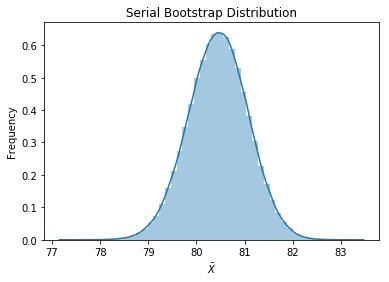

In [25]:
plt.title("Serial Bootstrap Distribution")
plt.xlabel(r"$\bar{X}$")
plt.ylabel("Frequency");
sns.distplot(boot_sample_means_serial);

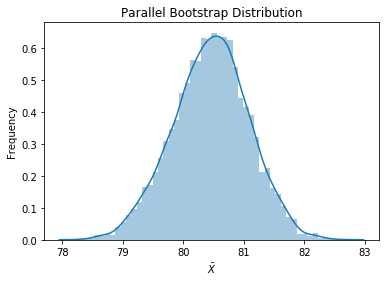

In [26]:
plt.title("Parallel Bootstrap Distribution")
plt.xlabel(r"$\bar{X}$")
plt.ylabel("Frequency");
sns.distplot(boot_sample_means_parallel);

At a high level, you parallelized a slow piece of code by splitting it into many tasks, and then *reduced* the result of the individual tasks to produce a output identical to the slow code.

In addition, you specifically parallelized the `for` loop in `bootstrap_serial` to speed up bootstrap. Parallelizing loops can often speed up code which allows data scientists to process data more quickly.

This idea of parallelizing certain code and reducing the results led to a more general programming model used to reason about and implement parallel programs called MapReduce. We'll introduce and implement MapReduce in Problem 3.

## 3: Implementing MapReduce

[MapReduce](https://en.wikipedia.org/wiki/MapReduce) a computational pattern for computing aggregate statistics of large datasets. It is the core primitive in systems like MapReduce, Hadoop, and Spark.

At its core, MapReduce consists of two primitives:

- The **map** transformation takes a dataset and a function and applies the function to each data point.
- The **reduce** transformation aggregates the output of the map stage.

For example, suppose that our starting point is a collection of documents. If we wish to count the number of occurrences of each word in the document, we can first apply a "map" transformation, which turns each document into a dictionary mapping words to the number of occurrences within that document. Then we can apply the "reduce" transformation, which sums the counts for each word.

### Question 3a
Implement `map_parallel` using the Ray API. We have provided a `map_serial` implementation for you.

In [27]:
def map_serial(function, element_lst):
    """Apply a function to each element of a list
    Args:
        function: a function that takes in one argument as input and outputs a value
        element_lst: a list of elements that function will be applied to
    Returns:
        A list of all of the elements each transformed by the function
        (ie [function(elem_1), function(elem_2), ..., function(elem_n)])
    """
    return [function(elem) for elem in element_lst]


map_serial(lambda x: x * x, [1, 2, 3, 4, 5])

[1, 4, 9, 16, 25]

In [28]:
def map_parallel(function, arglist):
    """Apply a function to each element of a list in parallel.
    Args:
        function: a remote function that takes in one argument as input and outputs an ObjectID
        arglist: a list of arguments that the function will be applied to
    Returns:
        A list of ObjectIDs
    """
    if not isinstance(arglist, list):
        raise ValueError("The arglist argument must be a list.")
    
    if not hasattr(function, "remote"):
        raise ValueError("The function argument must be a remote function.")
            
    # YOUR CODE HERE
    return [function.remote(i) for i in arglist]
    #raise NotImplementedError()

In [29]:
# Sanity check, this should pass if you implemented everything correctly
@ray.remote
def square_remote(x):
    return x * x


arglist = [1, 2, 3, 4, 5]

with timeit('parallel'):
    result_ids = map_parallel(square_remote, arglist)

assert isinstance(result_ids[0], ray.ObjectID), "map_parallel should return a list of ObjectIDs"

result_ray = ray.get(result_ids)

with timeit('serial'):
    result_serial = map_serial(lambda x: x * x, arglist)

assert result_ray == result_serial

parallel: 0.0005769003182649612 s elapsed
serial: 5.600042641162872e-06 s elapsed


You may notice that for a simple function like square operating on a small list of arguments, `map_parallel` is slower than `map_serial`. The difference in speed is due to communication and data transfer overhead between the processes which Ray uses to run functions in parallel.

In general, functions that are called often and take a long time to run are good targets for parallelization. We'll explore such an example using some of Shakespeare's works in later questions.

### Question 3b
Implement `reduce_parallel` using the Ray API. We have provided a `reduce_serial` implementation for you.

In [30]:
def reduce_serial(function, items):
    """Apply a function repeatedly to pairs of items until only 1 remains
    
    Args:
        function: remote function that takes 2 items as input and returns 1 new item.
        items: a list of items which are reduced to 1 output by repeatedly calling function.
    
    Example:
    ```
    >>> reduce_serial(sum, [1,2,3])
    6
    >>> reduce_serial(lambda x, y: x - y, [3,2,1])
    0
    ```
    
    Returns the resulting item.
    """
    if len(items) == 1:
        return items[0]
    
    result = items[0]
    for i in range(1, len(items)):
        result = function(result, items[i])

    return result

In [31]:
def reduce_parallel(function, items):
    """Apply a function repeatedly to pairs of items until only 1 remains.
    
    Args:
        function: remote function that takes 2 items as input and returns 1 new item.
        items: a list of items which are reduced to 1 output by repeatedly calling function.
    
    Returns an ObjectID.
    
    Hint:
        1. Divide the list of items into pairs.
        2. Reduce each pair to generate a new list of items.
        3. If there was an unpaired item in (1), add it to the new list.
        The new list should be about 1/2 the size of the old list.
        4. If there is only 1 item in the new list, return that item. Otherwise, repeat steps 1-3.
        
        This algorithm is called a "tree-reduce", where the original items are the leaves
        and the final result is the root. The tree is balanced. Each non-leaf node has 2 child nodes.
        Each non-root node has 1 parent node.
    """
    if not isinstance(items, list):
        raise ValueError("The items argument must be a list.")

    if not hasattr(function, "remote"):
        raise ValueError("The function argument must be a remote function.")
       
    items = items.copy()   # Avoids mutating the items argument
    if len(items)==1:
        return items[0]
    while(len(items))>1:
        myresult=function.remote(items[0],items[1])
        items=items[2:]+[myresult]
    return items[0]
        
    # YOUR CODE HERE
    #raise NotImplementedError()

In [32]:
def add_normal(a, b):
    # Simulate a longer running function
    # Necessary to check the correct implementation for reduce_parallel
    time.sleep(0.3)
    return a + b


@ray.remote
def add_remote(a, b):
    # Simulate a longer running function
    # Necessary to check the correct implementation for reduce_parallel
    time.sleep(0.3)
    return a + b


items = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

start_time = time.time()
result_serial = reduce_serial(add_normal, items)
time_serial = time.time() - start_time

start_time = time.time()
result_id = reduce_parallel(add_remote, items)
result_parallel = ray.get(result_id)
time_parallel = time.time() - start_time


assert result_serial == result_parallel

assert time_serial > time_parallel, "reduce_parallel is slower than reduce_serial" 

assert time_serial > 2 * time_parallel, "reduce_parallel is too slow" 

print(f"Time serial: {time_serial}")
print(f"Time parallel: {time_parallel}")

Time serial: 2.7034993171691895
Time parallel: 1.2078778743743896


## 4: Analyzing Word Frequency using MapReduce
Let's analyze the frequency of words used in Shakespeare. For this question, you'll need to do the following:
1. Download the text of a few of Shakespeare's plays.
2. For each play, count the number of times each word occurs.
3. Merge the word frequencies across plays.

We've provided some helper functions that will help you with this problem below.

In [33]:
def download_text(url):
    """Returns the string of text on some webpage"""
    request = urllib.request.urlopen(url)
    return request.read().decode("utf-8")


@ray.remote
def download_text_remote(url):
    return download_text(url)

In [34]:
def count_words(text):
    """Finds the frequency of each word in a string"""
    assert isinstance(text, str), "text should be a string"
    
    frequency = dict()
    
    text = text.lower()
    matches = re.findall(r"\b\w+\b", text)
    
    for word in matches:
        count = frequency.get(word, 0)
        frequency[word] = count + 1
        
    return frequency


@ray.remote
def count_words_remote(text):
    return count_words(text)

In [35]:
def merge_dicts(a, b):
    """Merges 2 dictionaries such that the result contains keys of both a and b.
    
    If a key k is in a and in b, result[k] = a[k] + b[k].
    """
    result = a.copy()  # Don't mutate the input dictionaries
    for key, value in b.items():
        result[key] = result.get(key, 0) + value
        
    return result


@ray.remote
def merge_dicts_remote(a, b):
    return merge_dicts(a, b)

In [36]:
urls = [
    "https://www.gutenberg.org/files/1524/1524-0.txt",       # Hamlet
    "https://www.gutenberg.org/cache/epub/2264/pg2264.txt",  # Macbeth
    "https://www.gutenberg.org/cache/epub/2267/pg2267.txt",  # Othello
    "https://www.gutenberg.org/cache/epub/1777/pg1777.txt",  # Romeo and Juliet
]

### Question 4
Speed up the code in the cell below using the MapReduce API. You'll need to use both `map_parallel` and `reduce_parallel`.

**HINT 1:** Parallelizing loops often speeds up code.

**HINT 2:** If you did question 3 correctly, you should be able to write 1 line solutions for the `...`

In [37]:
# Parallelize the following code using the MapReduce API
start_time = time.time()

total_frequencies_serial = {}
for url in urls:
    # Download the text of the play
    text = download_text(url)
    # Count the frequency of each word in the play
    frequencies = count_words(text)
    # Add the play's word frequencies to the global word frequencies
    total_frequencies_serial = merge_dicts(total_frequencies_serial, frequencies)
    
word_freq_time_serial = time.time() - start_time
print("Word frequency count serial completed in {} seconds".format(word_freq_time_serial))

Word frequency count serial completed in 7.924659490585327 seconds


In [38]:
start_time = time.time()

# Try to do these in one line!
text_ids = map_parallel(download_text_remote,urls)
frequency_ids = map_parallel(count_words_remote,text_ids)
total_frequency_id = reduce_parallel(merge_dicts_remote,frequency_ids)
total_frequencies_ray = ray.get(total_frequency_id)
# YOUR CODE HERE
# raise NotImplementedError()

word_freq_time_parallel = time.time() - start_time
print("Word frequency count parallel completed in {} seconds".format(word_freq_time_parallel))

Word frequency count parallel completed in 5.7046403884887695 seconds


In [39]:
assert total_frequencies_ray == total_frequencies_serial
assert word_freq_time_parallel < word_freq_time_serial

Let's examine some of Shakespeare's most used words. Surprised?

In [40]:
def most_used_words(freq_dict, num_words=10):
    ordered_keys = sorted(freq_dict, key=freq_dict.get, reverse=True)
    return [word for _, word in zip(range(num_words), ordered_keys)]

most_used_words(total_frequencies_ray, 10)

['the', 'and', 'to', 'i', 'of', 'a', 'you', 'my', 'that', 'in']

## 5: Ray Actors
So far, we have explored Ray's *remote functions*. The tasks generated by invoking remote functions are stateless in the sense that they are intended to map inputs to outputs without side effects. But suppose we want state to be shared and mutated by multiple tasks. In this case, we can use [Ray's *actors*](https://ray.readthedocs.io/en/latest/actors.html) to encapsulate mutable state.

*Optional:* Take a look at one interesting example of how to implement [distributed training with a parameter server using Ray actors](https://ray-project.github.io/2018/07/15/parameter-server-in-fifteen-lines.html). 

To create an actor, we decorate a Python class with the `@ray.remote` decorator.

In [41]:
@ray.remote
class Counter(object):
    def __init__(self):
        self.value = 0
    
    def increment(self):
        self.value += 1
    
    def get_value(self):
        return self.value

We can create an actor instance by invoking `.remote()` on the actor class. This starts a new actor process, which holds a copy of the `Counter` object.

In [42]:
c = Counter.remote()

We can run tasks on the actor process by invoking the actor's methods. These methods can mutate the actor's internal state (in this case, the field `self.value`). The actor executes tasks serially.

In [43]:
x1_id = c.increment.remote()
print("The actor's value is {}.".format(ray.get(c.get_value.remote())))

x2_id = c.increment.remote()
print("The actor's value is {}.".format(ray.get(c.get_value.remote())))

The actor's value is 1.
The actor's value is 2.


Suppose we want multiple tasks, actors, or processes to invoke methods on a single actor. In this case, we can pass *actor handles* around between tasks. In the example below, we pass a handle to the counter actor to a handful of tasks executing in parallel.

In [44]:
@ray.remote
def increment_counter(c):
    for _ in range(10):
        x_id = c.increment.remote()

    # Wait for the last increment call to complete before returning.
    ray.get(x_id)


initial_value = ray.get(c.get_value.remote())

# Start 4 tasks that run in parallel and all increment the counter.
increment_results = [increment_counter.remote(c) for _ in range(4)]

# Wait for all tasks to finish
ray.get(increment_results)

new_value = ray.get(c.get_value.remote())

print("The actor's value was {} and now it is {}.".format(initial_value, new_value))
assert new_value - initial_value == 4 * 10

The actor's value was 2 and now it is 42.


### Question 5
This question will take a different approach to solving the word-count problem from question 3.

Instead of launching four tasks that compute word counts and then aggregating the results on the "driver" process that issued the tasks, we are going to create a separate `ResultAggregator` actor for doing the aggregation. We will start four tasks that each compute frequencies for a given URL and then push those frequencies to the aggregator. The main "driver" process will then fetch the aggregated results from the aggregator.

The code below implements a serial version of this.

In [45]:
class ResultAggregator(object):
    """Aggregates word frequencies"""
    def __init__(self):
        self.total_frequencies = {}
    
    def add_frequencies(self, frequencies):
        """Adds a new dictionary mapping words to word frequencies to the overall word frequencies"""
        self.total_frequencies = merge_dicts(self.total_frequencies, frequencies)
    
    def get_frequencies(self):
        """Returns a dictionary mapping each word to its frequency"""
        return self.total_frequencies


def add_results(url, result_aggregator):
    """Downloads text from the url, counts the word frequencies, and adds the result to result_aggregator"""
    # Download the text of the play
    text = download_text(url)
    # Count the frequency of each word in the play
    frequencies = count_words(text)
    # Add the results to the aggregator
    done = result_aggregator.add_frequencies(frequencies)


result_aggregator = ResultAggregator()

start_time = time.time()

get_and_add_frequencies = [add_results(url, result_aggregator) for url in urls]
# ray.get(get_and_add_frequencies)

# Get the results
total_frequencies = result_aggregator.get_frequencies()

end_time = time.time()
print("Counting the words took {} seconds.".format(end_time - start_time))

most_used_words(total_frequencies, 10)

Counting the words took 2.8416669368743896 seconds.


['the', 'and', 'to', 'i', 'of', 'a', 'you', 'my', 'that', 'in']

Now implement a parallel version in which `ResultAggregator` is an actor, and `add_results` is a remote function.

In [46]:
@ray.remote
class ResultAggregator(object):
    """Aggregates word frequencies"""
    def __init__(self):
        self.total_frequencies = {}
    
    def add_frequencies(self, frequencies):
        """Adds a new dictionary mapping words to word frequencies to the overall word frequencies"""
        self.total_frequencies = merge_dicts(self.total_frequencies, frequencies)
    
    def get_frequencies(self):
        """Returns a dictionary mapping each word to its frequency"""
        return self.total_frequencies

@ray.remote
def add_results(url, result_aggregator):
    """Downloads text from the url, counts the word frequencies, and adds the result to result_aggregator"""
    # Download the text of the play
    text = download_text(url)
    # Count the frequency of each word in the play
    frequencies = count_words(text)
    # Add the results to the aggregator
    done = result_aggregator.add_frequencies.remote(frequencies)

start_time = time.time()

# Create an instance of a ResultAggregator actor
result_aggregator = ResultAggregator.remote()

# Call the add_results remote function on each URL
get_and_add_frequencies = [add_results.remote(i,result_aggregator) for i in urls]

# Wait for all add_results remote functions to complete
# uncomment this when get_add_frequencies is defined
ray.get(get_and_add_frequencies)

# Get the results from the actor
total_frequencies = ray.get(result_aggregator.get_frequencies.remote())

# YOUR CODE HERE
#raise NotImplementedError()

end_time = time.time()
print("Counting the words took {} seconds.".format(end_time - start_time))

most_used_words(total_frequencies, 10)

Counting the words took 6.349140644073486 seconds.


['the', 'and', 'to', 'i', 'of', 'a', 'you', 'my', 'that', 'in']

## 6: Modin

Now that you have learned how to parallelize your applications on a low level, let's take a look at a library that uses Ray to parallelize data science workflows. 

`Modin` is a DataFrame library that allows you to speed up your pandas workflows _by changing one line of code_. One of the main challenges with pandas is that it can be slow because it is only using a single CPU core on your machine. With Ray, Modin uses all the cores on your machine to make running pandas code faster!

To use Modin, replace the following line in your pandas notebook:

```python
# import pandas as pd
import modin.pandas as pd
```

After this, if you do not have a Ray instance started, Modin will automatically start one. In this notebook, we have used Ray before, so Modin will automatically connect to the Ray instance we started above.

### Question 6

This question relates to using Modin instead of pandas on your existing workflow.

We have already learned about pandas and how it can be used in different ways. Suppose we have already built a notebook to do some analysis in pandas. Change the following code to use Modin instead of pandas, and complete the analysis.

Note: Do not worry if you see a ray.init warning after running the next cell.

In [47]:
# Modin pandas version
import modin.pandas as pd
import numpy as np
import time
np.random.seed(21919)

frame_data = np.random.randint(0, 100, size=(2**19, 2**6))
df = pd.DataFrame(frame_data).add_prefix("col_")

Calling ray.init() again after it has already been called.


In [48]:
start_time = time.time()
# Perform a sum on the DataFrame object
sums = df.sum()

# YOUR CODE HERE
#raise NotImplementedError()

end_time = time.time()
print("In Modin, sum on {} rows took {} seconds.".format(len(df.index), end_time - start_time))

KeyboardInterrupt: 

In [ ]:
# Regular pandas version
import pandas
pandas_df = pandas.DataFrame(frame_data).add_prefix("col_")
start_time = time.time()
pandas_sums = pandas_df.sum()
end_time = time.time()
print("In pandas, sum on {} rows took {} seconds.".format(len(df.index), end_time - start_time))
assert pandas_sums.equals(sums)

## Optional: Distributed K-means Clustering

Let's parallelize an algorithm designed to find clusters of data.

[*K-means*](https://en.wikipedia.org/wiki/K-means_clustering) is an unsupervised algorithm that partitions $n$ data points into $k$ clusters where each data point belongs to the cluster with the nearest mean data point or *centroid*.

The algorithm works as follows:
1. Initialize the centroids $c_1, \dots, c_k$ randomly.
2. Assign each data point $d_j$ to the cluster belonging to the closest centroid. In mathematical terms, generate sets $S_1, \dots S_k$ s.t.
$S_i = \{d_j : || d_j - c_i || < || d_j - c_l || \quad \forall j, k \quad 1 \leq j \leq n \quad 1 \leq l \leq k \}$
3. Calculate $c_1', \dots, c_k'$ s.t. $c_i' \leftarrow \text{mean}(S_i)$.
4. If none of the centroids change, finish! In other words, $c_1 = c_1' \cap \dots \cap c_k = c_k'$. 
Then, $c_1', \dots, c_k'$ are the centroids of the clusters defined by $S_1, \dots S_k$.
5. Otherwise, assign $c_1 \leftarrow c_1', \dots, c_k \leftarrow c_k'$.
6. Return to step 2.

For our purposes, we'll make a small modification to the algorithm. Instead of assigning each data point to a set 
$S_i$ and then computing $c_i' \leftarrow \text{mean}(S_i)$, we'll only store the number of data points and the sum of the data points in each cluster.
This allows us to compute the mean centroid because:

$$\text{mean}(S_i) = \frac{\text{sum}(S_i)}{|S_i|}$$

$|S_i|$ corresponds to the number of data points in cluster $i$. $\text{sum}(S_i) = \sum_{d \in S_i} d$ corresponds to the sum of the data points in cluster $i$.


Here's some additional explanations that you might find useful:
- [K-means on Wikipedia](https://en.wikipedia.org/wiki/K-means_clustering)
- [Stanford CS221 on K-means](http://stanford.edu/~cpiech/cs221/handouts/kmeans.html)
- [Visualing K-means](http://tech.nitoyon.com/en/blog/2013/11/07/k-means/)


Familliarize yourself with the non-parallel k-means implementation below.

In [ ]:
def generate_centroid():
    """Generates a random centroid"""
    return np.random.random(size=2)


def generate_samples(num_samples, num_clusters, std=0.1):
    """Generates samples for some number of cluster according to a normal distribution"""
    centroids = [generate_centroid() for _ in range(num_clusters)]
    
    samples = []
    for i, centroid in enumerate(centroids):
        current_num_samples = num_samples // num_clusters
        if i == 0:
            current_num_samples += num_samples % num_clusters
        
        generated_samples = np.random.normal(centroid, std, (current_num_samples, 2))
        samples.append(generated_samples)
        
    samples = np.concatenate(samples)
    np.random.shuffle(samples)  # Occurs in-place
    return samples

NUM_CLUSTERS = 4
NUM_SAMPLES = 1000
samples = generate_samples(NUM_SAMPLES, NUM_CLUSTERS, 0.05)

In [ ]:
def k_means_serial(samples, num_clusters):
    """Finds num_clusters centroids for the samples using k-means"""
    np.random.seed(0)  # Generate centroids in a predictable way so k-means runs deterministically
    centroids = [generate_centroid() for _ in range(num_clusters)]
    
    old_centroids = []
    while not np.array_equal(centroids, old_centroids):
        sums = [0 for _ in range(num_clusters)]
        counts = [0 for _ in range(num_clusters)]
        # Classify the samples
        for sample in samples:
            cluster = 0
            min_dist = np.linalg.norm(sample - centroids[0])
            
            for i, centroid in zip(range(1, num_clusters), centroids[1:]):
                dist = np.linalg.norm(sample - centroid)
                if dist < min_dist:
                    cluster = i
                    min_dist = dist
            # Record the sums and counts to later compute the new centroids
            sums[cluster] += sample
            counts[cluster] += 1
        
        old_centroids = centroids
        centroids = [s / count if count > 0 else generate_centroid() for s, count in zip(sums, counts)]
                        
    np.random.seed(None)  # Reset random seed
        
    return centroids

In [ ]:
start = time.time()
serial_centroids = k_means_serial(samples, NUM_CLUSTERS)
k_means_serial_time = time.time() - start
print("k_means_serial took {} seconds.".format(k_means_serial_time))

Now, let's parallelize the k-means algorithm above. Once again, we'll parallelize the `for` loop in `k_means_serial` and parallelize the classification of data points. Classifying a single data point is very fast -- faster than the overhead needed to start a remote function. In this case, parallelizing across individual data points doesn't make sense. Instead, we'll parallelize across *batches* of data points -- larger sets of data points that are still smaller than the overall dataset.

**HINT:** use the MapReduce API.

In [ ]:
def make_remote_batch_classifier(centroids):
    """Returns a remote function that classifies each data point in a batch"""
    @ray.remote
    def classify_remote(samples):
        """Classifies each data point in the batch.
        
        Returns a dictionary containing the sum and number of data points in the batch for each cluster.
        """
        data = {}
        
        for sample in samples:
            cluster = 0            
            # YOUR CODE HERE: classify the data point by assigning `cluster` to the cluster number
            # that the data point belongs to.
            # YOUR CODE HERE
            raise NotImplementedError()
            
            sum_key = "{}_sum".format(cluster)
            count_key = "{}_count".format(cluster)
            data[sum_key] = data.get(sum_key, 0) + sample
            data[count_key] = data.get(count_key, 0) + 1
            
        return data
    
    return classify_remote


def k_means_parallel(samples, num_clusters):
    """Finds num_clusters centroids for the samples using parallelize k-means"""
    np.random.seed(0)  # Generate centroids in a predictable way so k-means runs deterministically
    centroids = [generate_centroid() for _ in range(num_clusters)]
    
    num_batches = int(ray.global_state.cluster_resources()["CPU"])
    
    # YOUR CODE HERE: Divide samples into `num_batches` batches.
    # Make sure batch sizes are roughly similar
    batches = ...
    # YOUR CODE HERE
    raise NotImplementedError()
    
    # YOUR CODE HERE: `ray.put` each batch. This eliminates overhead of repeatedly copying
    # batches to Ray's object store when calling remote functions on a batch
    batch_ids = ...
    # YOUR CODE HERE
    raise NotImplementedError()
    
    old_centroids = []
    while not np.array_equal(centroids, old_centroids):
        remote_classifier = make_remote_batch_classifier(centroids)
        
        # YOUR CODE HERE: Classify each batch in parallel using `remote_classifier`
        batch_info_dicts_ids = ...
        # YOUR CODE HERE
        raise NotImplementedError()
        
        # YOUR CODE HERE: use `merge_dicts_remote` to merge all batch_dict_ids into 1 dictionary 
        centroid_info = ...
        # YOUR CODE HERE
        raise NotImplementedError()
        
        old_centroids = centroids
        centroids = []
        for i in range(num_clusters):
            sum_key = "{}_sum".format(i)
            count_key = "{}_count".format(i)
            cluster_sum = centroid_info.get(sum_key, 0)
            cluster_count = centroid_info.get(count_key, 0)
            if cluster_count == 0:
                new_centroid = generate_centroid()
            else:
                # YOUR CODE HERE: compute the new centroid
                new_centroid = ...
                # YOUR CODE HERE
                raise NotImplementedError()
            
            centroids.append(new_centroid)
            
    np.random.seed(None)  # Reset the random seed
            
    return centroids

In [ ]:
start = time.time()
centroids = k_means_parallel(samples, NUM_CLUSTERS)
k_means_parallel_time = time.time() - start
print("k_means_parallel took {} seconds.".format(k_means_parallel_time))
assert np.allclose(serial_centroids, centroids)  # np.allclose avoids floating point issues

You may observe that the serial code runs faster than the parallel code. In this case, the slowdown for the parallel code is likely due to overhead in running remote functions and serializing data.

Because k-means initializes centroids randomly, the number of loop iterations to converge on the final set of centroids may vary. This means that running k-means multiple times on the same dataset could take different amounts of time. This should not cause any issues on this homework because we set the random seed to deterministically initialize centroids.

Let's try k-means on a 5x larger dataset -- 5000 data points instead of 1000. The performance gain from parallelizing k-means should outweigh the overhead and parallel k-means should run faster.

In [ ]:
# Run on a large dataset. This might take up to a minute.
NUM_SAMPLES = 5000
samples = generate_samples(NUM_SAMPLES, NUM_CLUSTERS, 0.05)

start = time.time()
serial_centroids = k_means_serial(samples, NUM_CLUSTERS)
k_means_serial_time = time.time() - start

start = time.time()
centroids = k_means_parallel(samples, NUM_CLUSTERS)
k_means_parallel_time = time.time() - start

print("k_means_serial took {} seconds.".format(k_means_serial_time))
print("k_means_parallel took {} seconds.".format(k_means_parallel_time))

The parallel version of K-means should run much faster.

Now, let's visualize the cluster centers you found!

In [ ]:
voronoi = scipy.spatial.Voronoi(centroids)
scipy.spatial.voronoi_plot_2d(voronoi, show_vertices=False, point_size=20)
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.1, color="orange")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("Voronoi Diagram")

## Other Links

You've seen above how Ray makes it easy to implement a system like MapReduce as a library on top of Ray. A handful of libraries have been implemented on top of Ray. You may be interested in taking a look at the following:
- [*Tune*: Distributed hyperparameter search](https://ray.readthedocs.io/en/latest/tune.html)
([github](https://github.com/ray-project/ray/tree/master/python/ray/tune))
- [*RLlib*: Scalable reinforcement learning](https://ray.readthedocs.io/en/latest/rllib.html)
([github](https://github.com/ray-project/ray/tree/master/python/ray/rllib))
- [*Modin*: Speeding up Pandas](https://modin.readthedocs.io/en/latest/)
([github](https://github.com/modin-project/modin))

Ray, Tune, RLlib, and Modin are research projects in UC Berkeley's RISElab. If you're interested in contributing, take a look at the project's codebase on Github!

## Submission

You're almost done!

Before submitting this assignment, ensure that you have:

1. Restarted the Kernel (in the menubar, select Kernel$\rightarrow$Restart & Run All)
2. Validated the notebook by clicking the "Validate" button.

Then **submit** the assignment via the Assignments tab in **Datahub** 